### MNIST fetching

In [1]:
from sklearn.datasets import fetch_mldata,load_digits
import numpy as np

In [2]:
#mnist = fetch_mldata('MNIST original', data_home='data/mnist/')
#np.save('data/mnist/mnist', mnist.data)
#mnist = mnist.data
mnist = load_digits().data.reshape((-1,8,8))

-----

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})

In [4]:
%env THEANO_FLAGS="device=gpu4"
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
from lasagne.regularization import regularize_network_params, l2
from lasagne.objectives import binary_crossentropy
from lasagne.nonlinearities import leaky_rectify, linear, sigmoid, rectify

theano.config.floatX = 'float32'

env: THEANO_FLAGS="device=gpu4"


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '44939' (I am process '45698')
Using gpu device 4: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [5]:
mnistX = mnist.astype(np.float32)
mnistX = (mnistX - np.mean(mnistX))/np.std(mnistX)

In [6]:
IMG_SHAPE = (8,8)

In [7]:
mnistX = mnistX.reshape((-1, 1, IMG_SHAPE[0], IMG_SHAPE[1]))

In [8]:
inputX = T.tensor4('input_img', 'float32') # [batch_size, num_channels, height, width]
#inputY = T.vector('input_labels') # [batch_size] of zeros or ones
inputZ = T.matrix('input_noise', 'float32')

CODE_SIZE = 32 # size of uniform noise

class generator:
    l_in = InputLayer((None, CODE_SIZE), input_var=inputZ, name='g_input')

    l_dense0 = DenseLayer(l_in,8**3,nonlinearity=T.tanh)
    
    l_reshape = ReshapeLayer(l_dense0, (-1, 8, 8, 8), name='dense_reshaped')
    
    l_deconv = Deconv2DLayer(l_reshape, 32, 5, nonlinearity=rectify, name='g_deconv0')

    l_gen = Conv2DLayer(l_deconv, 1, 5, nonlinearity=linear, name='g_gen_conv')
    
    assert len(l_gen.output_shape)==4 and l_gen.output_shape[1:] == (1,)+IMG_SHAPE    
    weights = get_all_params(l_gen, trainable=True)
    
    sample = theano.function([inputZ],get_output(l_gen))
    
    
class discriminator:
    l_in = InputLayer((None, 1, IMG_SHAPE[0], IMG_SHAPE[1]), name='d_input')
    l_conv0 = Conv2DLayer(l_in, 32, 5, nonlinearity=rectify)
    l_dense0 = DenseLayer(l_conv0, 128)
    l_prob = DenseLayer(l_dense0,1,nonlinearity=sigmoid)
        
    weights = get_all_params(l_prob, trainable=True)
    
    predict = theano.function([inputX],get_output(l_prob,inputX))
    
class training:
    
    #D(data)
    p_real_is_real = get_output(discriminator.l_prob, inputs=inputX).clip(1e-5,1.0-1e-5)
    
    #D(G(z))
    generated_img = get_output(generator.l_gen)
    p_gen_is_real = get_output(discriminator.l_prob, generated_img).clip(1e-5,1.0-1e-5)
    
    ########################
    ###generator training###
    ########################
    
    g_loss = -T.log(p_gen_is_real).mean()
    g_updates = lasagne.updates.adagrad(g_loss, generator.weights, 0.01)
    g_train_step = theano.function([inputZ], g_loss, updates=g_updates, allow_input_downcast=True)

    
    ########################
    #discriminator training#
    ########################
    d_loss = -(T.log(p_real_is_real) + T.log(1-p_gen_is_real)).mean()

    d_updates = lasagne.updates.adagrad(d_loss, discriminator.weights, 0.01)
    d_train_step = theano.function([inputX, inputZ], d_loss, updates=d_updates, allow_input_downcast=True)
    

### Auxilary functions
Sampling, visualization

In [9]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(mnistX.shape[0]), size=bsize)
    return mnistX[idxs]
def sample_images(nrow,ncol):
    images = generator.sample(sample_noise_batch(bsize=nrow*ncol))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(images[i].reshape(IMG_SHAPE))
    plt.show()
def sample_probas(bsize):
    plt.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),label='D(x)')
    plt.hist(discriminator.predict(generator.sample(sample_noise_batch(bsize))),label='D(G(z))')
    plt.legend(loc='best')
    plt.xlim(0,1)
    plt.show()

### Training

0.2420932948589325


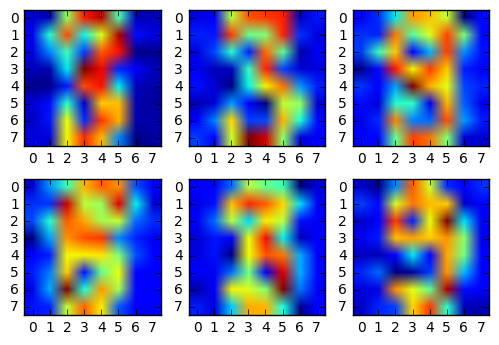

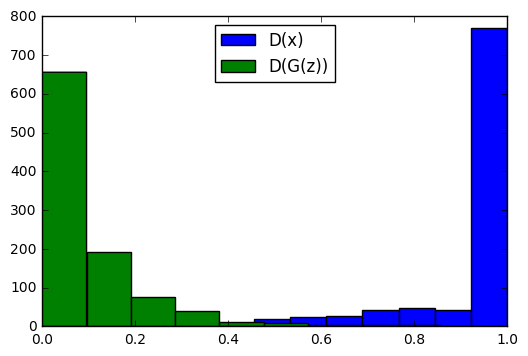

  3%|▎         | 2964/100000 [00:30<14:37, 110.59it/s]

In [ ]:
from IPython import display
from tqdm import tqdm
for epoch in tqdm(range(100000)):
    for i in range(5):
        training.d_train_step(sample_data_batch(100), sample_noise_batch(100))
    training.g_train_step(sample_noise_batch(100))
    if epoch %1000==0:
        display.clear_output(wait=True)
        print(training.d_train_step(sample_data_batch(100), sample_noise_batch(100)))
        sample_images(2,3)
        sample_probas(1000)
        